In [1]:
import pandas as pd
import numpy as np
from glob import glob
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
%load_ext line_profiler

## Data

In [306]:
def _prepare_data(patterns, random_seed:int=2019):
    filepaths = glob(pattern)
    data = pd.concat([pd.read_csv(f, index_col=0, parse_dates=['closed_date', 'created_date']) for f in filepaths], sort=False)
    
    data = data[data.complaint_type.str.lower().str.contains('noise')]
    data.reset_index(drop=True, inplace=True)
    data = data.dropna(subset=['x_coordinate_state_plane', 'y_coordinate_state_plane', 'created_date', 'closed_date', 'complaint_type', 'open_data_channel_type'])
    
    
    sample = data.sample(1000, random_state=random_seed)
    
    X = pd.concat([sample[['x_coordinate_state_plane',
                     'y_coordinate_state_plane']],
                   sample['created_date'].dt.dayofweek,
                   sample['created_date'].dt.hour,
                   sample['created_date'].dt.dayofyear],
              sort=False, axis=1)
    
    y = (data['closed_date'] - data['created_date']).dt.seconds / 3600 
    
    return X, y

In [358]:
pattern = '../Chapter15/data/311/2019/05/*.csv'

In [308]:
X, y = _prepare_data(pattern, random_seed=2019)

In [16]:
S = StandardScaler()

In [17]:
X = pd.DataFrame(S.fit_transform(X), columns=X.columns, index=X.index)

In [18]:
X = X.sample(10000, random_state=2019)
y = y[X.index]

In [20]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=2019)

# 1. "Naive" pandas model

In [124]:
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import r2_score, median_absolute_error

def _closest_N(X1, X2, N=1):
    matrix = euclidean_distances(X1, X2)
    args = np.argsort(matrix, axis=1)[:, :N]
    return args


class NearestNeighbor:
    X = None
    y = None
    N = None
    
    
    def __init__(self, N=3):
        self.N=N
    
    def fit(self, X, y):
        self.X = X
        self.y = y
    

    def predict(self, X):
        closest = _closest_N(X, self.X, N=self.N)
        
        result = pd.Series(np.mean(np.take(ytrain.values, closest), axis=1))
        result.index = X.index
        return result
        

In [125]:
naiveKNN = NearestNeighbor(N=5)

In [126]:
naiveKNN.fit(Xtrain, ytrain)

In [127]:
ypred = naiveKNN.predict(Xtest)

In [128]:
median_absolute_error(ytest, ypred)

1.8564722222222225

## Let's Time it

In [129]:
Xtest.shape

(2500, 5)

In [130]:
%%timeit
_ = naiveKNN.predict(Xtest)

1.47 s ± 54.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [131]:
%lprun -f naiveKNN.predict naiveKNN.predict(Xtest)

Timer unit: 1e-06 s

Total time: 1.38968 s
File: <ipython-input-124-90edea23066c>
Function: predict at line 24

Line #      Hits         Time  Per Hit   % Time  Line Contents
    24                                               def predict(self, X):
    25         1    1388815.0 1388815.0     99.9          closest = _closest_N(X, self.X, N=self.N)
    26                                                   
    27         1        851.0    851.0      0.1          result = pd.Series(np.mean(np.take(ytrain.values, closest), axis=1))
    28         1         18.0     18.0      0.0          result.index = X.index
    29         1          1.0      1.0      0.0          return result

In [132]:
%lprun -f _closest_N naiveKNN.predict(Xtest)

Timer unit: 1e-06 s

Total time: 1.44122 s
File: <ipython-input-124-90edea23066c>
Function: _closest_N at line 4

Line #      Hits         Time  Per Hit   % Time  Line Contents
     4                                           def _closest_N(X1, X2, N=1):
     5         1     196149.0 196149.0     13.6      matrix = euclidean_distances(X1, X2)
     6         1    1245072.0 1245072.0     86.4      args = np.argsort(matrix, axis=1)[:, :N]
     7         1          1.0      1.0      0.0      return args

## More thorough version

In [133]:
def _test_closest(f):
    x1 = pd.DataFrame({'a':[1,2], 'b':[20,10]})
    x2 = pd.DataFrame({'a':[2,1, 0], 'b':[10,20, 25]})
 
    answer = np.array([[1,0, 0]]).T
    assert np.all(f(x2, x1, N=1) == answer)

In [134]:
def _closest_N2(X1, X2, N=1):
    matrix = euclidean_distances(X1, X2)
    return np.argpartition(matrix, kth=N, axis=1)[:, :N]

In [135]:
_test_closest(_closest_N2)

In [148]:
class numpyNearestNeighbour(NearestNeighbor):
    
    
    def predict(self, X):
            closest = _closest_N2(X, self.X, N=self.N)
            return np.mean(np.take(self.y, closest), axis=1)

In [149]:
numpyKNN = numpyNearestNeighbour(N=5)
numpyKNN.fit(Xtrain.values, ytrain.values)

In [150]:
ypred = numpyKNN.predict(Xtest.values)

In [151]:
median_absolute_error(ytest.values, ypred)

1.852472222222222

In [152]:
Xtv = Xtest.values

In [153]:
%%timeit
_ = numpyKNN.predict(Xtv)

451 ms ± 18.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [143]:
%lprun -f _closest_N2 numpyKNN.predict(Xtv)

Timer unit: 1e-06 s

Total time: 0.440021 s
File: <ipython-input-134-29fa1851d880>
Function: _closest_N2 at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def _closest_N2(X1, X2, N=1):
     2         1     212103.0 212103.0     48.2      matrix = euclidean_distances(X1, X2)
     3         1     227918.0 227918.0     51.8      return np.argpartition(matrix, kth=N, axis=1)[:, :N]

## KDtree version

In [245]:
from scipy.spatial import cKDTree, KDTree

class kdNearestNeighbour:
    _kd = None
    y = None
    
    def __init__(self, N=3):
        self.N=N
    
    def fit(self, X, y):
        self._kd = cKDTree(X, leafsize=2*self.N)
        self.y = y
    

    def predict(self, X):
        d, closest = self._kd.query(X, k=self.N)
        return d, np.mean(np.take(ytrain.values, closest), axis=1)
  

In [198]:
kdKNN = kdNearestNeighbour(N=5)
kdKNN.fit(Xtrain.values, ytrain.values)

In [199]:
d, ypred = kdKNN.predict(Xtest.values)

In [203]:
type(ypred)

numpy.ndarray

1.852472222222222

In [164]:
%%timeit
_ = kdKNN.predict(Xtv)

11.3 ms ± 237 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [180]:
%lprun -f kdKNN.predict kdKNN.predict(Xtv)

Timer unit: 1e-06 s

Total time: 0.014067 s
File: <ipython-input-158-71e857f475e2>
Function: predict at line 14

Line #      Hits         Time  Per Hit   % Time  Line Contents
    14                                               def predict(self, X):
    15         1      13913.0  13913.0     98.9          d, closest = self._kd.query(X, k=self.N)
    16         1        154.0    154.0      1.1          return np.mean(np.take(ytrain.values, closest), axis=1)

# Dask

In [3]:
from dask import dataframe as dd
from dask import delayed

In [310]:
# %timeit _prepare_data(filepaths, random_seed=2019)

4.39 s ± 96.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [4]:
from dask import dataframe as dd
pattern = '../Chapter15/data/311/2019/05/*.csv'

df = dd.read_csv(pattern, blocksize=None, parse_dates=['closed_date', 'created_date'])

In [5]:
df = df[df.complaint_type.str.lower().str.contains('noise')]
cols = ['x_coordinate_state_plane', 'y_coordinate_state_plane', 'created_date', 'closed_date', 'complaint_type', 'open_data_channel_type']

df = df.dropna(subset=cols)

X = df[['x_coordinate_state_plane', 'y_coordinate_state_plane']]
X['dow'] = df['created_date'].dt.dayofweek
X['hour'] = df['created_date'].dt.dayofweek
X['doy'] = df['created_date'].dt.dayofyear

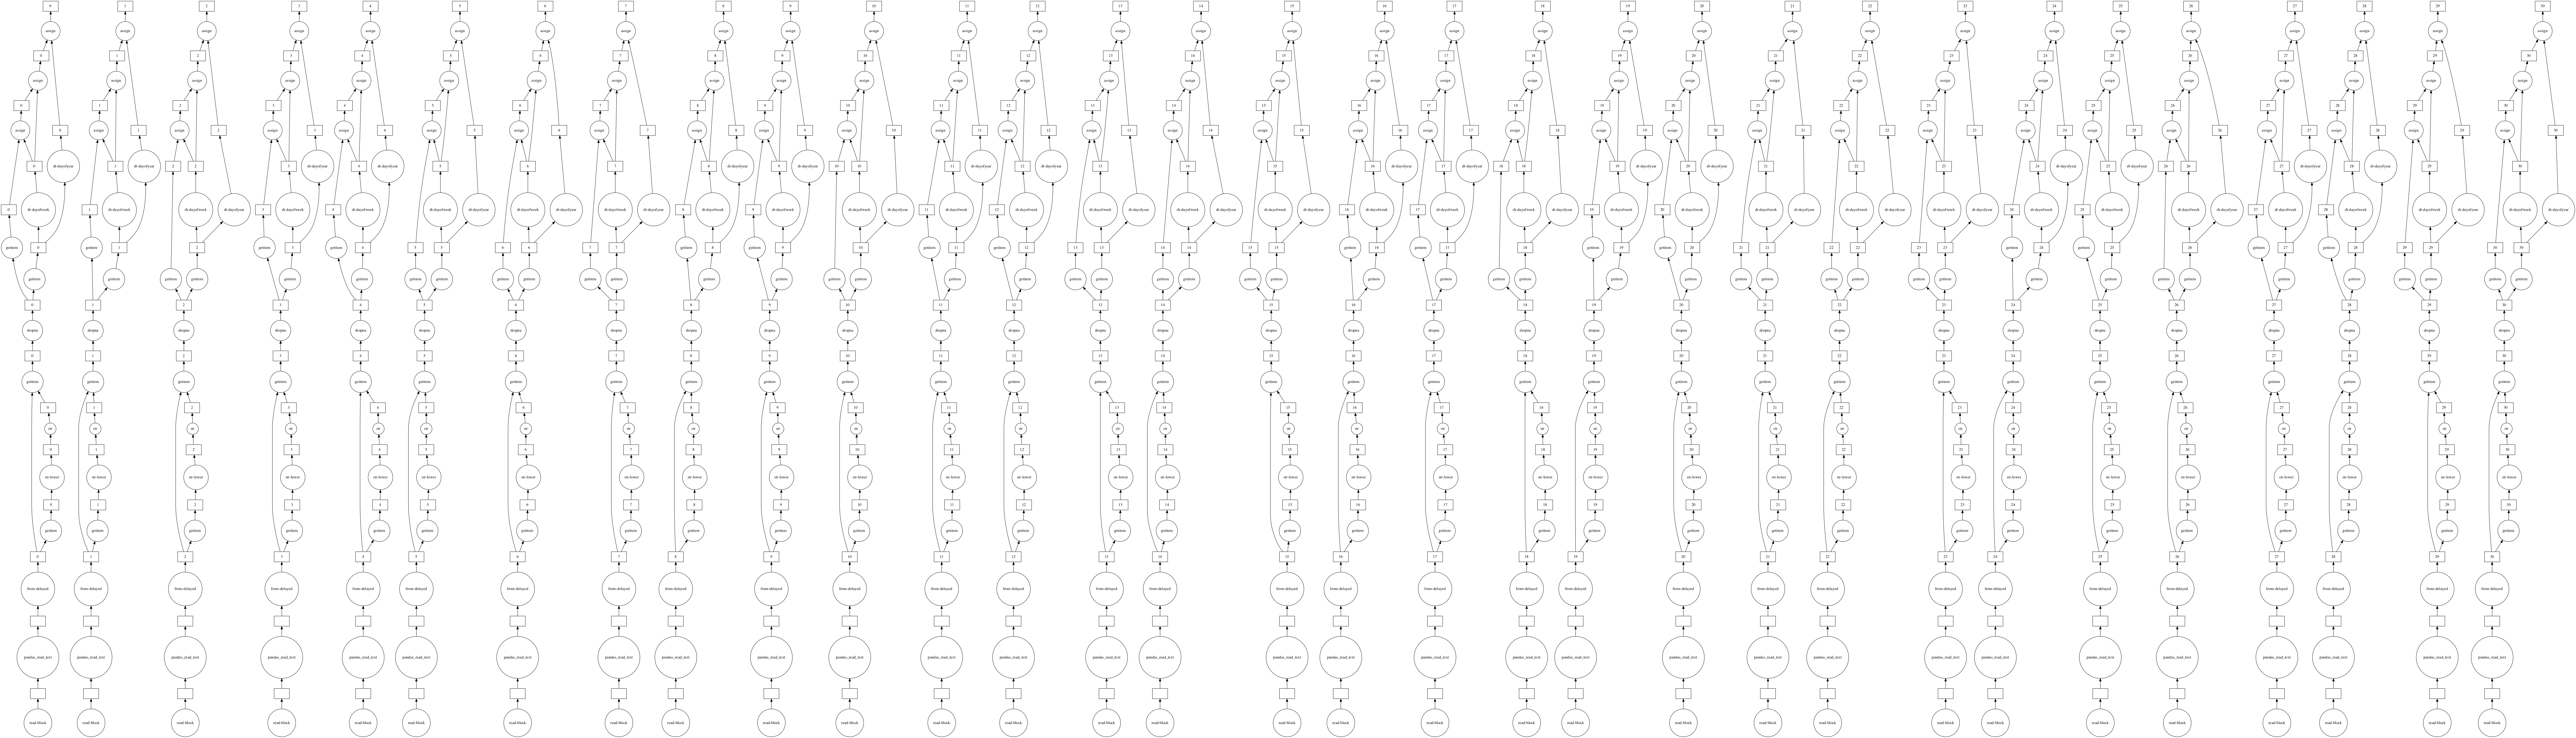

In [8]:
X.visualize(filename='chart.png')

In [356]:
filenames = glob(pattern)
dfs = [delayed(pd.read_csv)(fn, index_col=0, parse_dates=['closed_date', 'created_date']) for fn in filenames]
data = dd.from_delayed(dfs)

In [357]:
df = data.compute()

AttributeError: 'list' object has no attribute 'compute'

In [348]:
cols = ['x_coordinate_state_plane', 'y_coordinate_state_plane', 'created_date', 'closed_date', 'complaint_type', 'open_data_channel_type']
data = data[cols].dropna()

In [351]:
sample = data.compute()

ValueError: Length mismatch: Expected axis has 42 elements, new values have 40 elements

In [328]:
X2, y2 = dask_prepare_data(filepaths)

ValueError: Length mismatch: Expected axis has 41 elements, new values have 40 elements

# Numba

In [9]:
import numba
from numba import jit, vectorize, generated_jit
from numba.types import iterators

In [17]:
def distance(p1, p2):
    
    distance = 0
    for c1, c2, in zip(p1,p2):
        distance += (c2-c1)**2
    
    return np.sqrt(distance)



def compute_distances(points1, points2):
    A = np.zeros(shape=(len(points1), len(points2)))
                 
    for i, p1 in enumerate(points1):
        for j, p2 in enumerate(points2):
                 A[i, j] = distance(p1, p2)
    
    return A

In [18]:
%timeit compute_distances([(0, 0)]*100, [(1,1)]*200)

43.8 ms ± 1.46 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [23]:
@jit()
def distance(p1, p2):
    
    distance = 0
    for c1, c2, in zip(p1,p2):
        distance += (c2-c1)**2
    
    return np.sqrt(distance)


@jit()
def compute_distances(points1, points2):
    A = np.zeros(shape=(len(points1), len(points2)))
                 
    for i, p1 in enumerate(points1):
        for j, p2 in enumerate(points2):
                 A[i, j] = distance(p1, p2)
    
    return A

In [24]:
%timeit compute_distances([(0, 0)]*100, [(1,1)]*200)

/Users/philippk/anaconda3/envs/py37b/lib/python3.7/site-packages/numba/ir_utils.py:1958: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'points1' of function 'compute_distances'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-23-34196df9bc05>", line 12:
@jit()
def compute_distances(points1, points2):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/Users/philippk/anaconda3/envs/py37b/lib/python3.7/site-packages/numba/ir_utils.py:1958: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'points2' of function 'compute_distances'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File

3.02 ms ± 101 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [301]:

specs = {
    'X':float64[:, :],
    'y': float64[:],
    'N': int32
}

@jitclass(specs)
class numbaNearestNeighbor:
    
    
    def __init__(self, N=3):
        self.N=N
    
    def fit(self, X, y):
        self.X = X
        self.y = y
    
    def _compute_distances(self, x1, x2):
        '''here x1 and x2 are arrays of dictionaries'''

    def predict(self, X):
        matrix = euclidean_distances(X1, X2)
        closest = np.argpartition(matrix, kth=self.N, axis=1)[:, :self.N]
        
        return np.mean(np.take(self.y.values, closest), axis=1)

In [302]:
knnn = numbaNearestNeighbor(N=5)

In [303]:
knnn.fit(Xtrain.values, ytrain.values)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mFailed in nopython mode pipeline (step: nopython frontend)
[1mUntyped global name 'euclidean_distances':[0m [1m[1mcannot determine Numba type of <class 'function'>[0m
[1m
File "<ipython-input-301-76b9663591d0>", line 23:[0m
[1m    def predict(self, X):
[1m        matrix = euclidean_distances(X1, X2)
[0m        [1m^[0m[0m
[0m
[0m[1m[1] During: resolving callee type: BoundFunction((<class 'numba.types.misc.ClassInstanceType'>, 'predict') for instance.jitclass.numbaNearestNeighbor#7fe9a82e2b58<X:array(float64, 2d, A),y:array(float64, 1d, A),N:int32,matrix:array(float64, 2d, A),closest:array(int32, 2d, A)>)[0m
[0m[1m[2] During: typing of call at <string> (3)
[0m
[1m
File "<string>", line 3:[0m
[1m<source missing, REPL/exec in use?>[0m

This is not usually a problem with Numba itself but instead often caused by
the use of unsupported features or an issue in resolving types.

To see Python/NumPy features supported by the latest release of Numba visit:
http://numba.pydata.org/numba-doc/dev/reference/pysupported.html
and
http://numba.pydata.org/numba-doc/dev/reference/numpysupported.html

For more information about typing errors and how to debug them visit:
http://numba.pydata.org/numba-doc/latest/user/troubleshoot.html#my-code-doesn-t-compile

If you think your code should work with Numba, please report the error message
and traceback, along with a minimal reproducer at:
https://github.com/numba/numba/issues/new


In [287]:
%timeit _prepare_data(filepaths)

4.63 s ± 221 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [292]:

@jit(nopython=False)
def _prepare_data2(filepaths, random_seed:int=2019):
    data = pd.concat([pd.read_csv(f, index_col=0, parse_dates=['closed_date', 'created_date']) for f in filepaths], sort=False)
    
    data = data[data.complaint_type.str.lower().str.contains('noise')]
    data.reset_index(drop=True, inplace=True)
    data = data.dropna(subset=['x_coordinate_state_plane', 'y_coordinate_state_plane', 'created_date', 'closed_date', 'complaint_type', 'open_data_channel_type'])
    
    
    sample = data.sample(1000, random_state=random_seed)
    
    X = pd.concat([sample[['x_coordinate_state_plane',
                     'y_coordinate_state_plane']],
                   sample['created_date'].dt.dayofweek,
                   sample['created_date'].dt.hour,
                   sample['created_date'].dt.dayofyear],
              sort=False, axis=1)
    
    y = (data['closed_date'] - data['created_date']).dt.seconds / 3600 
    
    return X, y

In [293]:
%timeit _prepare_data2(pattern)

<ipython-input-292-9ee9c3f59821>:2: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "_prepare_data2" failed type inference due to: Unknown attribute 'concat' of type Module(<module 'pandas' from '/Users/philippk/anaconda3/envs/py37b/lib/python3.7/site-packages/pandas/__init__.py'>)

File "<ipython-input-292-9ee9c3f59821>", line 4:
def _prepare_data2(filepaths, random_seed:int=2019):
    data = pd.concat([pd.read_csv(f, index_col=0, parse_dates=['closed_date', 'created_date']) for f in filepaths], sort=False)
    ^

[1] During: typing of get attribute at <ipython-input-292-9ee9c3f59821> (4)

File "<ipython-input-292-9ee9c3f59821>", line 4:
def _prepare_data2(filepaths, random_seed:int=2019):
    data = pd.concat([pd.read_csv(f, index_col=0, parse_dates=['closed_date', 'created_date']) for f in filepaths], sort=False)
    ^

  @jit(nopython=False)
/Users/philippk/anaconda3/envs/py37b/lib/python3.7/site-packages/numba/compiler.py:725: Nu

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [276]:
X, y = _prepare_data(pattern)

In [271]:
nKNN.fit(Xtrain.values, ytrain.values)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mFailed in nopython mode pipeline (step: nopython frontend)
[1mUntyped global name 'KDTree':[0m [1m[1mcannot determine Numba type of <class 'type'>[0m
[1m
File "<ipython-input-269-efbc13ab6d4b>", line 17:[0m
[1m    def fit(self, X, y):
[1m        self._kd = KDTree(X, leafsize=2*self.N)
[0m        [1m^[0m[0m
[0m
[0m[1m[1] During: resolving callee type: BoundFunction((<class 'numba.types.misc.ClassInstanceType'>, 'fit') for instance.jitclass.numbaNearestNeighbour#7fe9a8600498<N:int32,y:array(float64, 1d, A)>)[0m
[0m[1m[2] During: typing of call at <string> (3)
[0m
[1m
File "<string>", line 3:[0m
[1m<source missing, REPL/exec in use?>[0m

This is not usually a problem with Numba itself but instead often caused by
the use of unsupported features or an issue in resolving types.

To see Python/NumPy features supported by the latest release of Numba visit:
http://numba.pydata.org/numba-doc/dev/reference/pysupported.html
and
http://numba.pydata.org/numba-doc/dev/reference/numpysupported.html

For more information about typing errors and how to debug them visit:
http://numba.pydata.org/numba-doc/latest/user/troubleshoot.html#my-code-doesn-t-compile

If you think your code should work with Numba, please report the error message
and traceback, along with a minimal reproducer at:
https://github.com/numba/numba/issues/new


In [242]:
ypred = nKNN.predict(Xtv)

<ipython-input-239-b4232752329b>:2: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "_predict" failed type inference due to: non-precise type pyobject
[1] During: typing of argument at <ipython-input-239-b4232752329b> (4)

File "<ipython-input-239-b4232752329b>", line 4:
def _predict(kd, X, y, N:int):
    d, closest = kd.query(X, k=N)
    ^

  @jit
/Users/philippk/anaconda3/envs/py37b/lib/python3.7/site-packages/numba/compiler.py:725: NumbaWarning: Function "_predict" was compiled in object mode without forceobj=True.

File "<ipython-input-239-b4232752329b>", line 3:
@jit
def _predict(kd, X, y, N:int):
^

  self.func_ir.loc))
/Users/philippk/anaconda3/envs/py37b/lib/python3.7/site-packages/numba/compiler.py:734: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit http://numba.pydata.org/numba-doc/latest/r

In [243]:
%%timeit
_ = nKNN.predict(Xtv)

12.1 ms ± 322 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
